# Fundamentos de analítica 2 (clase 5)

## Diego Fernando Agudelo
## Universidad ICESI
## diegoagudelo30@gmail.com

## **1. Carga de paquetes**

In [1]:
import numpy as np
import pandas as pd # Operaciones con dataframes
from matplotlib import pyplot as plt # gráficos
from statsmodels.tsa.seasonal import seasonal_decompose # descomposición de series
from statsmodels.tsa.holtwinters import SimpleExpSmoothing  # Holwinters simple
from statsmodels.tsa.holtwinters import ExponentialSmoothing # Holwinters doble y tripe
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_squared_error
!pip install fastai wwf bayesian-optimization -q --upgrade
from bayes_opt import BayesianOptimization

from statsmodels.stats.diagnostic import het_arch

from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.var_model import VARResults
#from statsmodels.tsa.vector_ar.var_model import VARSelect

from sklearn.model_selection import TimeSeriesSplit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 713.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 18.9 MB/s eta 0:00:00


## **2. Carga de datos**

Nuestra primera tarea será leer el archivo de Excel. Para eso podemos emplear el paquete Pandas. Carguemos los datos en un objeto que denominaremos data.

In [2]:
data = pd.read_csv("/content/data.csv")
data.head()

,y1,y2
0,0.292764,0.354733
1,-0.284374,0.126277
2,0.343942,-1.057280
3,0.675844,-0.397178
4,-0.326084,-0.374396


(202, 2)


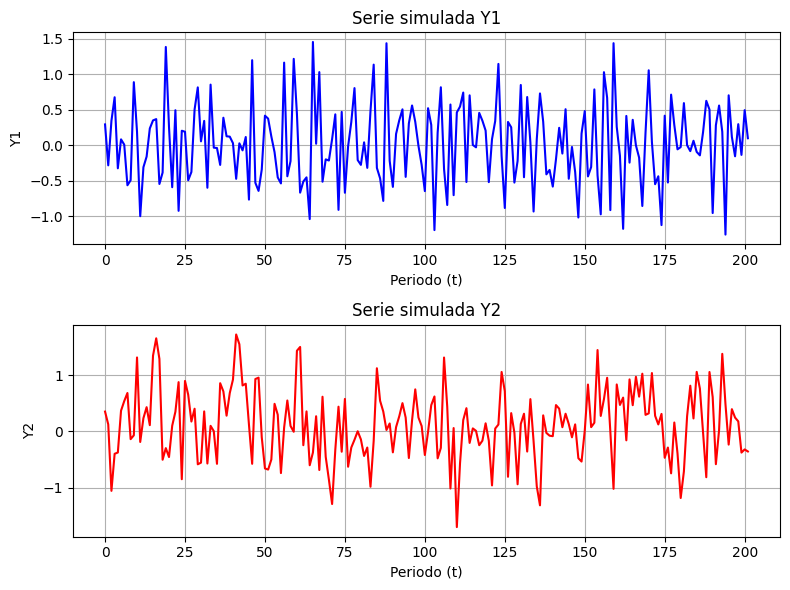

In [3]:
# imprimiendo el tamano del dataframe
print(data.shape)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

# Primer gráfico para la serie y1
ax1.set_title("Serie simulada Y1")
ax1.set_xlabel("Periodo (t)")
ax1.set_ylabel("Y1")
ax1.plot(data[["y1"]], color='blue')
ax1.grid()

# Segundo gráfico para la serie y2
ax2.set_title("Serie simulada Y2")
ax2.set_xlabel("Periodo (t)")
ax2.set_ylabel("Y2")
ax2.plot(data[["y2"]], color='red')
ax2.grid()

# Ajustar espaciado entre los subgráficos
plt.tight_layout()

# Mostrar los gráficos
plt.show()

## **3. Seleccionar el orden del modelo VAR**

In [4]:
model = VAR(data)
result = model.select_order()
result.summary()

,AIC,BIC,FPE,HQIC
0,-2.080,-2.046,0.1249,-2.066
1,-2.631,-2.528*,0.07201,-2.589*
2,-2.634,-2.462,0.07180,-2.564
3,-2.635*,-2.394,0.07174*,-2.537
4,-2.616,-2.306,0.07310,-2.491
5,-2.604,-2.225,0.07402,-2.450
6,-2.570,-2.122,0.07660,-2.388
7,-2.556,-2.040,0.07766,-2.347
8,-2.552,-1.967,0.07799,-2.315
9,-2.560,-1.905,0.07745,-2.294


## **4. Estimación del modelo**

In [37]:
model = VAR(data)
results = model.fit(2,trend="c")# trend =  c(Constante) , ct(Constante + tendencia lineal) ,ctt (Constante + tendencia lineal + tendencia cuadratica), n
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 13, Sep, 2024
Time:                     13:51:15
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -2.47564
Nobs:                     200.000    HQIC:                  -2.57382
Log likelihood:          -293.520    FPE:                  0.0713230
AIC:                     -2.64056    Det(Omega_mle):       0.0678863
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.071248         0.037066            1.922           0.055
L1.y1        -0.280622         0.070698           -3.969           0.000
L1.y2        -0.377608         0.068639           -5.501           0.000
L2.y1        -0.114461

<Axes: >

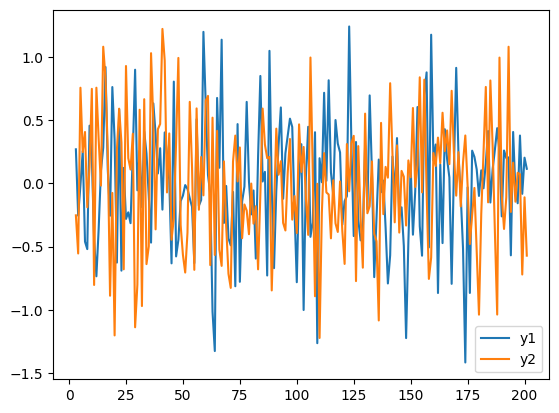

In [11]:
results.resid.plot()

In [19]:
lag_order = results.k_ar
results.forecast_interval (data.values[-lag_order:], 2)

(array([[ 0.09598223, -0.1188748 ],
        [-0.05909522,  0.04683363]]),
 array([[-0.87572797, -1.13342969],
        [-1.15413887, -1.19053282]]),
 array([[1.06769242, 0.89568008],
        [1.03594842, 1.28420008]]))

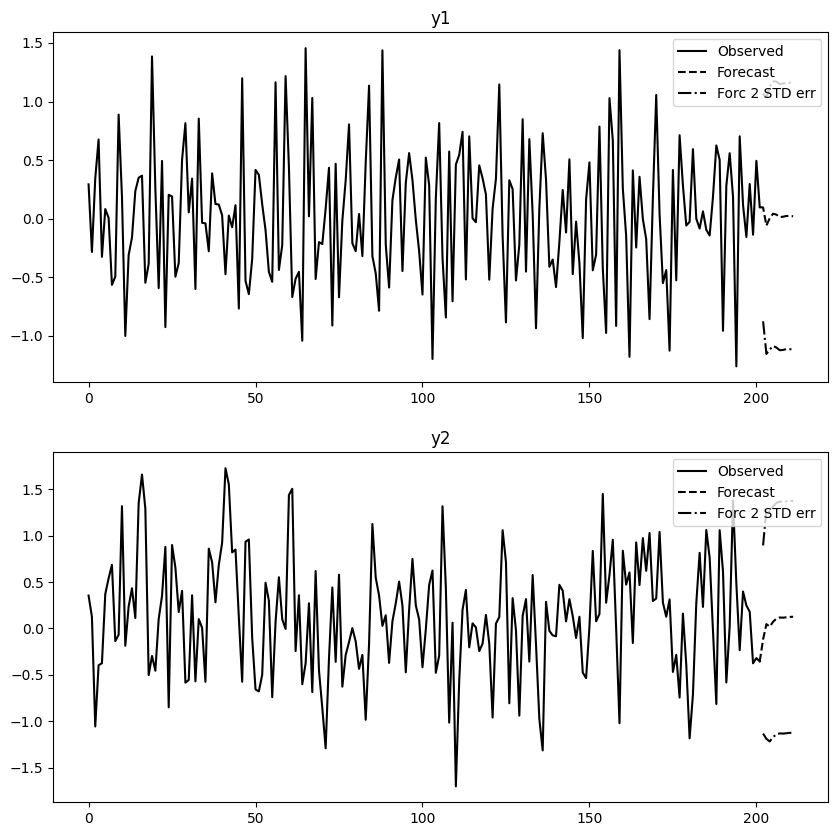

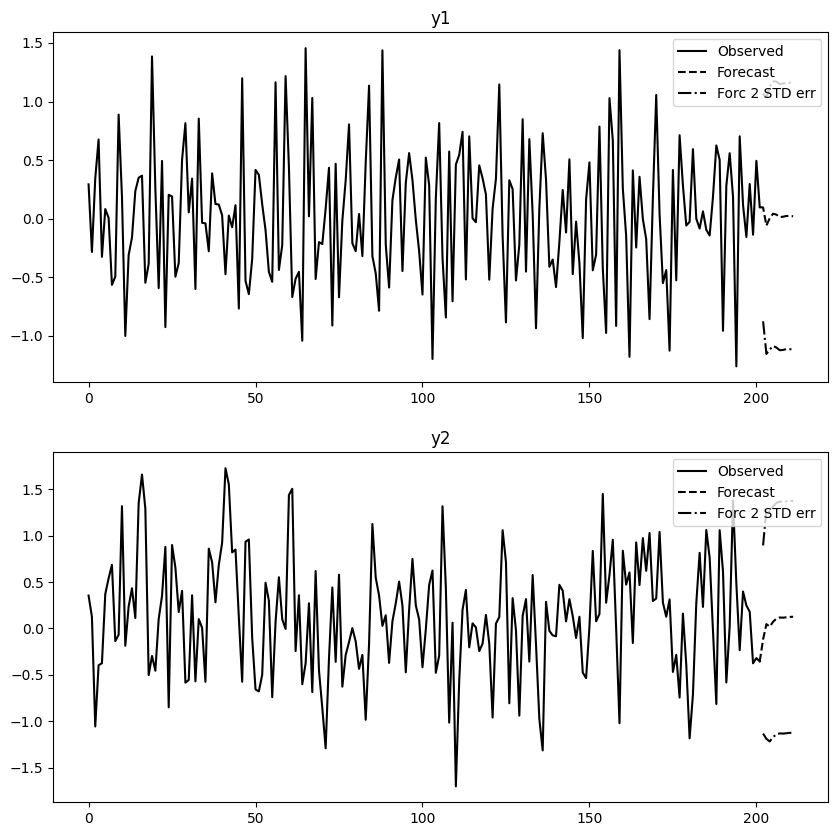

In [21]:
results.plot_forecast(10)

## **5. Causalidad a Granger**

Es un test consistente en comprobar si los resultados de una variable sirven para predecir a otra variable, si tiene carácter unidireccional o bidireccional. Para ello se tiene que comparar y deducir si el comportamiento actual y el pasado de una serie temporal A predice la conducta de una serie temporal B. Si ocurre el hecho, se dice que “el resultado A” causa en el sentido de Wiener-Granger “el resultado B”; el comportamiento es unidireccional. Si sucede lo explicado e igualmente “el resultado B” predice “el resultado A”, el comportamiento es bidireccional, entonces “el resultado A” causa “el resultado B”, y “el resultado B” causa “el resultado A”.

In [23]:
causa = results.test_causality('y2', ['y1'], kind='f')
causa.summary()

Test statistic,Critical value,p-value,df
24.08,2.628,0.000,"(3, 384)"


## **6. Autocorrelación**
$H{0}: ρ = 0$ (Es decir no hay autocorrelación)

$H{1}: ρ \not= 0$ (Es decir hay autocorrelación)

In [31]:
d=results.test_whiteness(4,adjusted =True )
d.summary()

Test statistic,Critical value,p-value,df
4.470,9.488,0.346,4


In [39]:
lag_pvalue = {}
lag_conclusion = {}
lag_conclusion1 = {}
for lag in range(3, 16):
    p_values = results.test_whiteness(lag,adjusted =True)
    lag_pvalue[lag] = p_values.pvalue
    lag_conclusion[lag] = p_values.conclusion
    lag_conclusion1[lag] = p_values.conclusion_str
df_results = pd.DataFrame({'p_value': lag_pvalue, 'conclusion': lag_conclusion1})

df_results["Conclusión_espanol"] = np.where(df_results['p_value']<0.05, 'rechazo_ho/hay_autocorr', 'no_rechazo_ho/no_hay_autocorr')
df_results

,p_value,conclusion,Conclusión_espanol
3,0.027876,Conclusion: reject H_0,rechazo_ho/hay_autocorr
4,0.063583,Conclusion: fail to reject H_0,no_rechazo_ho/no_hay_autocorr
5,0.180915,Conclusion: fail to reject H_0,no_rechazo_ho/no_hay_autocorr
6,0.338356,Conclusion: fail to reject H_0,no_rechazo_ho/no_hay_autocorr
7,0.245277,Conclusion: fail to reject H_0,no_rechazo_ho/no_hay_autocorr
8,0.103703,Conclusion: fail to reject H_0,no_rechazo_ho/no_hay_autocorr
9,0.148329,Conclusion: fail to reject H_0,no_rechazo_ho/no_hay_autocorr
10,0.265391,Conclusion: fail to reject H_0,no_rechazo_ho/no_hay_autocorr
11,0.357930,Conclusion: fail to reject H_0,no_rechazo_ho/no_hay_autocorr
12,0.456210,Conclusion: fail to reject H_0,no_rechazo_ho/no_hay_autocorr


### **7. Normalidad**

In [ ]:
d1 = results.test_normality()
d1.summary()

Test statistic,Critical value,p-value,df
2.356,9.488,0.671,4


## **8. Prueba de estacionariedad(raices unitarias)**

$H{0}: la serie de tiempo tiene raíz unitaria.

$H{1}: la serie de tiempo no tiene raíz unitaria.

In [ ]:
from statsmodels.tsa.stattools import adfuller

dk1 = adfuller(data["y1"])
print('ADF Statistic: %f' % dk1[0])
print('p-value: %f' % dk1[1])
print('Critical Values:')
for key, value in dk1[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.071784
p-value: 0.000016
Critical Values:
	1%: -3.465
	5%: -2.877
	10%: -2.575


## **9. Ejercicio en Clase**

Empleando la información las variables 'realgdp', 'realcons' y 'realinv' ajuste un modelo VAR y genere 5 pronósticos para cada variable.

In [ ]:

import numpy as np
import pandas
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.base.datetools import dates_from_str

mdata = sm.datasets.macrodata.load_pandas().data
dates = mdata[['year', 'quarter']].astype(int).astype(str)

quarterly = dates["year"] + "Q" + dates["quarter"]
quarterly = dates_from_str(quarterly)

mdata = mdata[['realgdp','realcons','realinv']]
mdata.index = pandas.DatetimeIndex(quarterly)

In [ ]:
mdata

,realgdp,realcons,realinv
1959-03-31,2710.349,1707.4,286.898
1959-06-30,2778.801,1733.7,310.859
1959-09-30,2775.488,1751.8,289.226
1959-12-31,2785.204,1753.7,299.356
1960-03-31,2847.699,1770.5,331.722
...,...,...,...
2008-09-30,13324.600,9267.7,1990.693
2008-12-31,13141.920,9195.3,1857.661
2009-03-31,12925.410,9209.2,1558.494
2009-06-30,12901.504,9189.0,1456.678
